In [128]:
import pandas as pd
import numpy as np

In [129]:
df = pd.read_csv('telco.csv')

### Categorizing Variables, Filling Missing and Binning where required

- Removed the variables that are not to be used.

In [130]:
target = 'Churn Label' # variables target 

# Feature Categorization for encoding and feature selection --------------------------------------------------------------------------------------------------------------------

var_not_used = ['Customer ID','Country','State','Latitude','Longitude','Quarter','Customer Status','Churn Score','CLTV','Churn Category','Churn Reason']

features = [col_name for col_name in df.columns if col_name not in [target] + var_not_used]

numerical_features = df[features].select_dtypes(include=np.number).columns.to_list()
categorical_features = df[features].select_dtypes(exclude=np.number).columns.to_list()

#Boolean variables
ordinal = ['Referred a Friend','Phone Service','Multiple Lines','Internet Service','Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data']

#Nominal Variables - categories that dont have a certain order to them
nominal = ['Gender', 'Under 30', 'Senior Citizen','Married','Dependents','Offer', 'Internet Type','Contract','Paperless Billing','Payment Method']

In [131]:
# Before we do prepreocessing using encoding pipelines filling in missing values, encoding and binning the variables where required
df[['Churn Category', 'Churn Reason']] = df[['Churn Category', 'Churn Reason']].fillna('not churned')

# Bin values for Tenure
bins = range(0,max(df['Tenure in Months'])+1,12)
df['Tenure in Months'] = pd.cut(df['Tenure in Months'],bins, labels=range(1,len(list(bins)),))


# Zipcode - needs encoding (as catgoric) - countencoding being done due to high cardinality
df['Zip Code'] = df['Zip Code'].astype(str)
count_map = df['Zip Code'].value_counts().to_dict()
df['Zip Code'] = df['Zip Code'].map(count_map)


### Preprocesing

- Created preprocessing pipeline using makepipeline of sklearn and encoders
- ordinal pipeline: Creates ordinal encoding and then scales the encoded values to be in range 0 to 1. we are encoding the variables which are binary valued with this method
- nominal pipeline: One-Hot encoding the nominal variables and dropping the first column to avoid multicolinearity
- numeric_pipeline : this pipeline applies a power transformation to numerical features using the Yeo-Johnson method and then scales the transformed features to a specified range. This preprocessing pipeline is useful for preparing numerical features for machine learning algorithms, especially those sensitive to the distribution of features.

In [132]:
# Creating Encoding pipelines for different types of variables
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer


ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=[['Yes','No']]*len(ordinal)), MinMaxScaler())
nominal_pipeline = make_pipeline(OneHotEncoder(drop='first'))
numeric_pipeline = make_pipeline(PowerTransformer('yeo-johnson'), MinMaxScaler())


preprocessing_pipeline = ColumnTransformer(transformers=[
    ('ordinal_pipeline',ordinal_pipeline,ordinal),
    ('nominal_pipeline',nominal_pipeline,nominal),
    ('numeric_pipeline',numeric_pipeline,numerical_features)
])


In [133]:
# Splitting dataset
y = df[target].replace({'Yes':1,'No':0})
X = df[features]

from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state= 201, stratify=y)

In [137]:
# X_train['Tenure in Months']

In [135]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [152]:
#First checking baseline models for accuracy comparision and then we will tune hyperparameters later

models= {
    'RF':RandomForestClassifier(random_state=201),
    'XGB': XGBClassifier(),
    'KNN':KNeighborsClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=201)
    }

result = []

for name,model in models.items():
    final_pipeline = make_pipeline(preprocessing_pipeline,model)
    cv = cross_validate(final_pipeline,X_train,y_train, cv = 5, return_train_score=True, scoring='roc_auc')
    result.append(pd.DataFrame(cv).mean().to_frame().set_axis([name],axis = 1))

In [153]:
score_result = pd.concat(result,axis=1)
score_result

,RF,XGB,KNN,CatBoost
fit_time,0.337415,0.147186,0.051482,2.042416
score_time,0.017121,0.008851,0.017198,0.015556
test_score,0.985777,0.992399,0.895582,0.993611
train_score,1.000000,1.000000,0.959247,0.999899


- Training and Test Scores are closer for CatBoost and train score not being 1 suggest lesser chances of overfitting. 
- CatBoost is better performing than KNN in this case as well, by a degree not achievable by hyperparameter tuning
- So we choose CatBoost here and plot our model evaluators for the same

In [156]:
catBoost_model = make_pipeline(preprocessing_pipeline,CatBoostClassifier(verbose=0, random_seed=201))
catBoost_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal_pipeline',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No']])),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Refer...
                                                   'Number of Dependents',
                                                   'Zip Code', 'Population',
                                                   'Number of Referrals',
                                                   'Tenure in Months',
                                                   'Avg Monthly Long Distance '
                                                   'Charges',
                                                   'Avg Monthly GB Download',
                                                   'Monthly Charge',
                                                   'Total Charges',
                                                   'Total Refunds',
                                                   'Total Extra Data Charges',
                                                   'Total Long Distance '
                                                   'Charges',
                                                   'Total Revenue',
                                                   'Satisfaction Score'])])),
                ('catboostclassifier',
    

In [163]:
results_dict = {
    'actual' : y_test,
    'pred' : catBoost_model.predict(X_test),
    'predicted_proba': catBoost_model.predict_proba(X_test)[:,1] #these probabilities are already normalized, this scoring method can be used for multiclass classifiers to evaluate proba for each class
}

results = pd.DataFrame(results_dict)

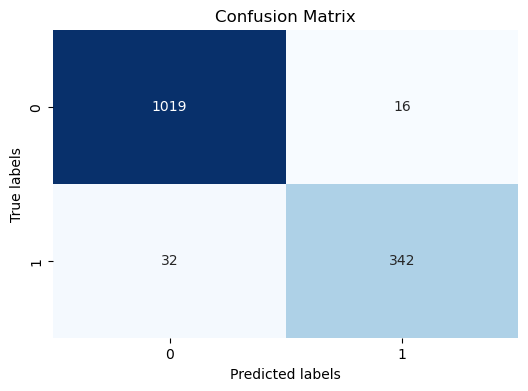

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test are the true labels and y_pred are the predicted labels
# Calculate confusion matrix
cm = confusion_matrix(y_test, catBoost_model.predict(X_test))

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [186]:
from sklearn.metrics import classification_report, accuracy_score

model_report = classification_report(y_test, catBoost_model.predict(X_test))

In [187]:
print(model_report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1035
           1       0.96      0.91      0.93       374

    accuracy                           0.97      1409
   macro avg       0.96      0.95      0.96      1409
weighted avg       0.97      0.97      0.97      1409



- Precision: The ratio of true positive predictions to the total number of positive predictions. It measures the accuracy of positive predictions.
- Recall: The ratio of true positive predictions to the total number of actual positives. It measures the model's ability to find all positive instances.
- F1-score: The harmonic mean of precision and recall. It provides a balance between precision and recall.
- Support: The number of actual occurrences of the class in the test set.
- Accuracy: The ratio of correctly predicted instances to the total number of instances.
- Macro avg: The average of precision, recall, and F1-score across all classes.
- Weighted avg: The weighted average of precision, recall, and F1-score, weighted by the number of instances of each class.

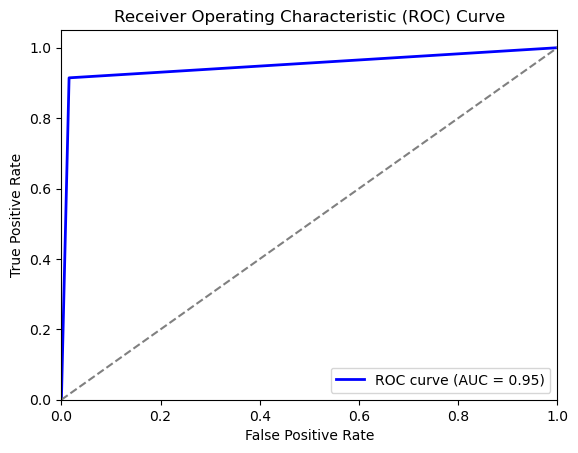

In [179]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test are the true labels and y_score are the predicted probabilities
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, catBoost_model.predict(X_test))

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


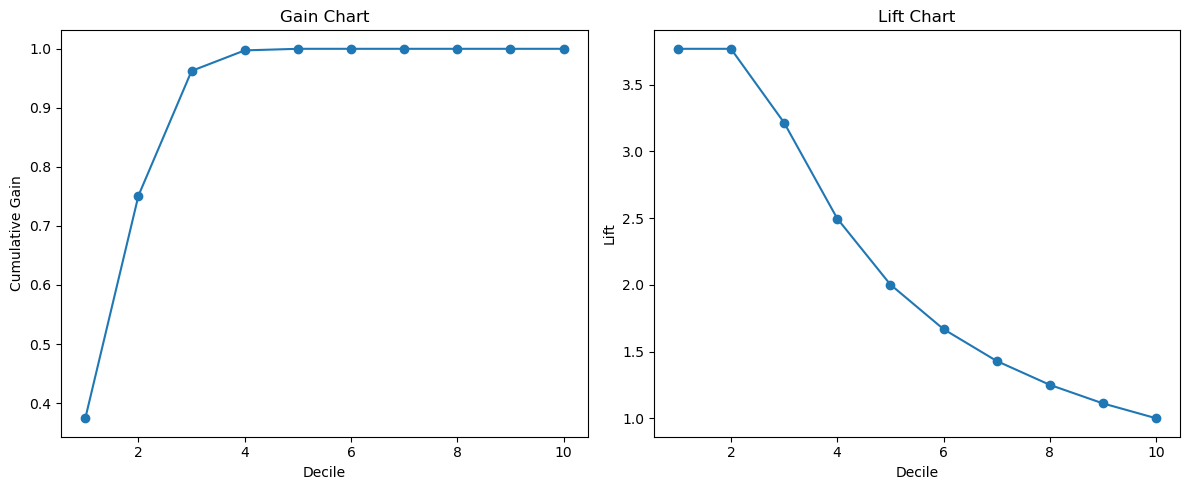

In [231]:
# Get predicted probabilities on the test set
y_prob = catBoost_model.predict_proba(X_test)[:, 1]

# Calculate gain and lift values
def calculate_gain_lift(y_test, y_prob, num_buckets=10):
    order = np.argsort(y_prob)[::-1]
    y_test_sorted = y_test[order]
    y_prob_sorted = y_prob[order]
    total_positives = np.sum(y_test)
    
    gains = []
    lifts = []
    for i in range(1, num_buckets + 1):
        bucket_size = int(len(y_prob) * i / num_buckets)
        bucket_true = y_test_sorted[:bucket_size]
        bucket_positives = np.sum(bucket_true)
        gains.append(bucket_positives / total_positives)
        lifts.append(bucket_positives / (total_positives * (bucket_size / len(y_prob))))
        
    return gains, lifts

gains, lifts = calculate_gain_lift(np.array(y_test), y_prob)

# Plot the gain and lift charts
num_instances = range(1, len(gains) + 1)

plt.figure(figsize=(12, 5))

# Gain Chart
plt.subplot(1, 2, 1)
plt.plot(num_instances, gains, marker='o')
plt.title('Gain Chart')
plt.xlabel('Number of Instances')
plt.ylabel('Cumulative Gain')

# Lift Chart
plt.subplot(1, 2, 2)
plt.plot(num_instances, lifts, marker='o')
plt.title('Lift Chart')
plt.xlabel('Number of Instances')
plt.ylabel('Lift')

plt.tight_layout()
plt.show()

In [229]:
np.array(y_test)

array([1, 0, 1, ..., 1, 1, 0])

In [238]:
# Business savings

churn_prevention_campaign_success_rate = 0.5
average_revenue = df['Total Revenue'].sum()/len(df)
churn_prediction_accuracy = accuracy_score(y_test, catBoost_model.predict(X_test))
event_rate = len(df[df['Churn Label'] == 'Yes'])/len(df)

total_customers = len(df)

average_savings_after_model = churn_prevention_campaign_success_rate * churn_prediction_accuracy * event_rate * total_customers * average_revenue

# print("Considering a total customer base of {:,} in california, a retention campaign success rate of {}% and an average revenue of ${:,}, Total savings achieved after deplopyment of this model for driving customer retention campaign will be for ${:,}M adding to a total revenue of ${:,}M."
#       .format(
#     total_customers,
#     round(churn_prevention_campaign_success_rate*100),
#     round(average_revenue),
#     round(average_savings_after_model/1000000,2),
#     round(df['Total Revenue'].sum()/1000000,2)
# ))

#### Considering a total customer base of 7,043 in california, a retention campaign success rate of 50% and an average revenue of $3,034, Total savings achieved after deplopyment of this model for driving customer retention campaign will be for $2.74M adding to a total revenue of $21.37M.


In [240]:
# Exporting the model as pkl file

import pickle

with open('.trained_catBoost_model.pkl', 'wb') as f:
    pickle.dump(catBoost_model,f)

print("successfully exported model. \n Model details:", catBoost_model)



successfully exported model. 
 Model details: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal_pipeline',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                                                                               'No'],
                                                                                              ['Yes',
                                               

### Next Steps

#### Todo: SHAP Summary

SHAP (SHapley Additive exPlanations) is a powerful tool for interpreting the output of machine learning models by explaining the contribution of each feature to the model's output

- The summary plot typically displays a horizontal bar chart where each feature is represented by a bar. The length of the bar indicates the magnitude of the feature's impact on the model's output, and the color indicates whether the feature's value is high (red) or low (blue). This visualization helps you understand which features are most important for the model's predictions and how they influence those predictions.

Others:
- Hyperparameter Tuning can be done to further improve accuracy
- Productionize the model using pickle and flaskAPI